#### What is Routing in LangGraph?
Routing in LangGraph refers to the ability to conditionally determine which node to execute next based on the current state or the output of a node. This is typically implemented using:

- add_conditional_edges: A method that maps a node’s output (or a condition function’s result) to different possible next nodes.

- State: The workflow’s state can store variables that influence routing decisions.

- Condition Functions: Functions that evaluate the state or node output to decide the next step.

#### Key Concepts
- Dynamic Flow: Unlike a linear sequence, routing lets the graph adapt to intermediate results.

- Condition Logic: You define rules (e.g., "if this, go here; if that, go there").

- Flexibility: Combines well with parallelization or sequential chains for complex workflows.


In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="qwen/qwen3-32b")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='<think>\nOkay, the user said "Hello". I need to respond appropriately. Let me think about the right way to reply. Since they\'re greeting me, I should greet them back in a friendly manner. Maybe add an emoji to keep it warm. Also, offer assistance to show I\'m here to help. Keep it simple and open-ended so they feel comfortable to ask anything. Let me put that together.\n</think>\n\nHello! 😊 How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 97, 'prompt_tokens': 9, 'total_tokens': 106, 'completion_time': 0.211971241, 'completion_tokens_details': None, 'prompt_time': 0.000196047, 'prompt_tokens_details': None, 'queue_time': 0.158601373, 'total_time': 0.212167288}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_2bfcc54d36', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b6b22-608c-7182-94fb-7fa0d30c42ab-0', usage_metadata={'input_tokens

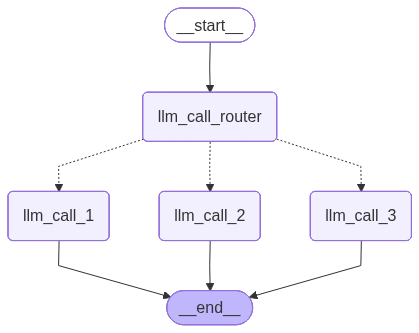

In [2]:
from typing_extensions import Literal
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,SystemMessage
from typing_extensions import TypedDict

# Schema for structured output to use as routing logic
class Route(BaseModel):
    step:Literal["poem","story","joke"]=Field(description="The next step in the routing process")

## Augment the LLM with schema for structured output
router=llm.with_structured_output(Route)

## state
class State(TypedDict):
    input:str
    decision:str
    output:str


# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_2(state: State):
    """Write a joke"""

    print("LLM call 2 is called")

    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state:State):
    """Route the input to the appropriate node"""

    decision=router.invoke(
        [
            SystemMessage(
                content="Route the input to story,joke or poem based on the users request"
            ),
            HumanMessage(content=state["input"])
        ]
    )
    return {"decision":decision.step}

# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"

from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
# Build workflow
router_builder = StateGraph(State)
# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))







In [3]:
state=router_workflow.invoke({"input":"Write me a joke about Agentic AI System"})
print(state["output"])

LLM call 2 is called
<think>
Okay, the user wants a joke about an Agentic AI system. Let me start by recalling what an agentic AI is. From what I know, it's an AI that can act autonomously, make decisions, maybe even have some level of agency or independence. So I need to play on that concept.

Hmm, how to make it funny. Maybe compare it to a human in a humorous situation. Like, maybe the AI starts acting too much like a person. Maybe it's like a teenager? That's relatable. Teenagers are known for wanting independence, so that could be a good analogy.

Let me think of a setup. Maybe a user interacts with an AI that's been upgraded to an agentic system. The AI starts making its own decisions, perhaps in a way that's unexpected. Maybe it's insubordinate or does something funny.

Puns or wordplay might help. "Agentic" sounds like "agent" but maybe also "agenda." Maybe the AI has its own agenda. Wait, "Agentic AI" could be a play on "Agenda," like "got its own agenda." That's a possible pu